In [1]:
%matplotlib inline

import pandas as pd
from scipy.spatial import distance
import math
import sys
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import statsmodels.api as sm
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from collections import Counter

/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
def preprocess_wic_sentences(filename):
    df = pd.read_csv("WiC_data/" + filename + "/" + filename + ".data.txt", sep = '\t', header=None)
    df.columns = ['og_keyword', 'og_pos', 'og_index', 'og_sentence1', 'og_sentence2']

    gold_labels = pd.read_csv("WiC_data/" + filename + "/" + filename + ".gold.txt", sep = '\t', header=None)
    gold_labels.columns=['human_label']
    gold_labels['human_label'] = gold_labels['human_label'].apply(lambda x: 0 if x == 'F' else 1)

    df = df.set_index(df.index).join(gold_labels.set_index(gold_labels.index))
    return df

In [3]:
#calculating cosine distances
def calculate_cosine_distances(embeddings, sentences):
    embeddings = embeddings.sort_values(by=1536)
    cosine_similarity_values = []
    t = embeddings.iterrows()
    for (i, row1), (j, row2) in zip(t, t):
        row1 = row1[0:768]
        row2 = row2[0:768]
        cosine_similarity_values.append(cosine_similarity([row1, row2])[0][1])
    sentences['cosine_similarity'] = cosine_similarity_values
    return sentences

In [4]:
#Various ways of matching keywords
def measure_same_word_form(df):
    words = df['og_keyword'].values
    exact_appearances = []
    exact_appearances_lower = []
    sents1 = df['og_sentence1'].values
    sents2 = df['og_sentence2'].values
    for i, word in enumerate(words):
        exact_count = 0
        exact_count_lower = 0        
        if word in sents1[i].split():
            exact_count += 1
        if word in sents2[i].split():
            exact_count += 1
        if word in sents1[i].lower().split():
            exact_count_lower += 1
        if word in sents2[i].lower().split():
            exact_count_lower += 1
        exact_appearances.append(exact_count)
        exact_appearances_lower.append(exact_count_lower)
            
    df['exact_match_count'] = exact_appearances
    df['same_wordform'] = exact_appearances_lower
    return df


In [5]:
#combine with frequency data
def combine_results_with_frequency(og_data):
    #keeping just a subset of columns for analysis
    results = og_data.set_index('og_keyword').join(freq.set_index("index"))[['human_label', 'freq', 'cosine_similarity', 'og_pos', 'exact_match_count', 'same_wordform']]

    #the words negociate, sumerize, ulteriority are not in our frequency data and dropped
    results = results.dropna()

    results['log2(freq)'] = results['freq'].apply(lambda x: math.log(x, 2))
    results['log2(freq)'].hist()
    return results


In [6]:
def calculate_num_senses(results):
    #calculating number of senses and synonyms for words we have
    senses = []
    for n, row in results.iterrows():
        word = n
        senses_num = len(wn.synsets(word))

        senses.append(senses_num)
    results['senses'] = senses

    results['log2(senses)'] = results['senses'].apply(lambda x: math.log(x, 2))
    results['log2(senses)'].hist()
    return results

In [7]:
#read in sentences
train_sentences = preprocess_wic_sentences("train")
dev_sentences = preprocess_wic_sentences("dev")

#read in embeddings
train_embeddings = pd.read_csv("embeddings/train_cased_embeddings_average.csv", header=None)
dev_embeddings = pd.read_csv("embeddings/dev_cased_embeddings_average.csv", header=None)

print("Original number of examples: ", len(train_sentences))
print("Original number of unique words in training data: ", len(set(train_sentences['og_keyword'].values)))

Original number of examples:  5428
Original number of unique words in training data:  1265


In [8]:
#read in frequency data
freq = pd.read_csv("../../utils/word_frequency/bert_word_frequencies.csv")


In [9]:
#Calculate cosine similarities
train_data = calculate_cosine_distances(train_embeddings, train_sentences)
dev_data = calculate_cosine_distances(dev_embeddings, dev_sentences)

In [10]:
#Calculating if word forms are the same
train_data = measure_same_word_form(train_data)
dev_data = measure_same_word_form(dev_data)


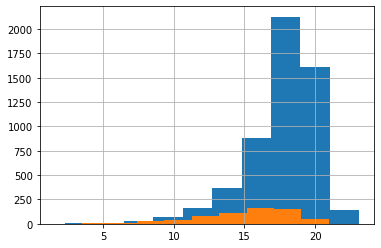

In [11]:
#combine data with frequency data
train_data = combine_results_with_frequency(train_data)
dev_data = combine_results_with_frequency(dev_data)


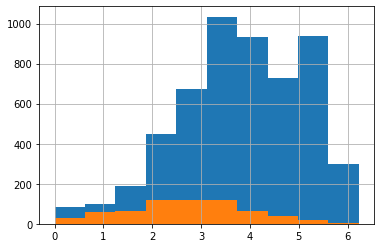

In [12]:
#calculat number of sentences
train_data = calculate_num_senses(train_data)
train_data = train_data.reset_index()

dev_data = calculate_num_senses(dev_data)
dev_data = dev_data.reset_index()

In [13]:
#calculate part of speech
train_data['is_noun'] = [1 if pos == 'N' else 0 for pos in train_data['og_pos']]
dev_data['is_noun'] = [1 if pos == 'N' else 0 for pos in dev_data['og_pos']]
train_data["freq_logged_bins"] = pd.qcut(train_data['freq'], q=10)


In [18]:
train_data = sm.add_constant(train_data)

subset0 = train_data[train_data['human_label']==0]
subset1 = train_data[train_data['human_label']==1]

# subset0, subset1
for df in [train_data]:
    variables = ['const']
    for variable in ['log2(freq)', 'log2(senses)', 'same_wordform','is_noun']:
        variables.append(variable)
        log_reg = sm.OLS(df['cosine_similarity'].values, df[variables].values).fit()
        print("\\begin{table*}[!h]")
        print(log_reg.summary(xname=variables, yname='Cosine Similarity'))
        print("\\end{table*}")

\begin{table*}[!h]
                            OLS Regression Results                            
Dep. Variable:      Cosine Similarity   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     893.3
Date:                Tue, 19 Apr 2022   Prob (F-statistic):          8.09e-182
Time:                        14:02:44   Log-Likelihood:                 5450.8
No. Observations:                5423   AIC:                        -1.090e+04
Df Residuals:                    5421   BIC:                        -1.088e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0206      0.008 

/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/seaborn/regression.py:592: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


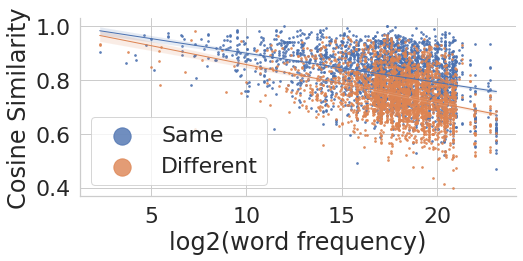

In [15]:
#create scatterplot with regression line

#updating labels for the figure
train_data['Human Label'] = train_data['human_label'].apply(lambda x: "Same" if x == 1 else "Different")

sns.set(rc={'figure.figsize':(6,3)}, style='whitegrid', font_scale=2,)
fig = sns.lmplot('log2(freq)', 'cosine_similarity', train_data, hue='Human Label', legend_out=False, 
                 fit_reg=True, scatter_kws={"s": 3, 'rasterized':True}, line_kws={"lw":1}, height=4, aspect=2)

fig.set_axis_labels("log2(word frequency)", "Cosine Similarity")
plt.legend(loc="lower left", markerscale=10)

plt.savefig('frequency_cosine_reg.pdf', bbox_inches='tight', dpi=600)



/u/nlp/anaconda/main/anaconda3/envs/katezhou/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


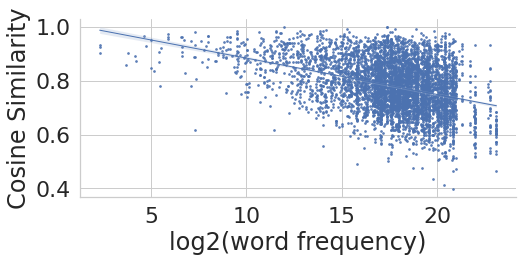

In [19]:
#create scatterplot with regression line

#updating labels for the figure
train_data['Human Label'] = train_data['human_label'].apply(lambda x: "Same" if x == 1 else "Different")

sns.set(rc={'figure.figsize':(6,3)}, style='whitegrid', font_scale=2,)
fig = sns.lmplot('log2(freq)', 'cosine_similarity', train_data, 
                 fit_reg=True, scatter_kws={"s": 3, 'rasterized':True}, line_kws={"lw":1}, height=4, aspect=2)

fig.set_axis_labels("log2(word frequency)", "Cosine Similarity")

plt.savefig('frequency_cosine_reg_all.pdf', bbox_inches='tight', dpi=600)



# Error Analysis

In [53]:
#finding threshold for classifier using only cosine similarity
def find_cosine_threshold(df):
    max_value = 0
    max_threshold = 0
    for x in range(0, 100, 2):
        threshold = x / 100
        df['cosine_label'] = df['cosine_similarity'].apply(lambda x: 1 if x > threshold else 0)
        if (len(df[df['cosine_label'] == df['human_label']])/ len(df) > max_value):
            max_value = len(df[df['cosine_label'] == df['human_label']])/ len(df)
            max_threshold = threshold
    return max_value, max_threshold

In [54]:
def applying_labels(df, max_threshold):
    #using the best threshold
    df['cosine_label'] = df['cosine_similarity'].apply(lambda x: 1 if x > max_threshold else 0)
    #change to binary correct labels
    df['correct'] = df['human_label'] == df['cosine_label']
    df['correct'] = df['correct'].apply(lambda x : 1 if x == True else 0)
    return df


In [ ]:
def calculate_mean_std(df):
    cosine_array = []
    human_array = []
    for x in range(0, 1000):
        bootstrap_sample = df.groupby(['freq_logged_bins']).apply(lambda x: x.sample(n=len(x), replace=True)).reset_index(drop=True)
        cosine_array.append(bootstrap_sample.groupby("freq_logged_bins").mean()['cosine_label'].values)
        human_array.append(bootstrap_sample.groupby("freq_logged_bins").mean()['human_label'].values)

    mean_cosine = np.array(cosine_array).mean(axis=0)
    mean_human = np.array(human_array).mean(axis=0)

    std_cosine = np.array(cosine_array).std(axis=0)
    std_human = np.array(human_array).std(axis=0)
    return mean_cosine, mean_human, std_cosine, std_human

In [57]:
#Finding binary threshold for cosine model
max_value, max_threshold = find_cosine_threshold(train_data)
print("Accuracy on training set:", max_value)
print("Binary threshold:", max_threshold)

#Apply labels from cosine model to dataset
train_data = applying_labels(train_data, max_threshold)
dev_data = applying_labels(dev_data, max_threshold)
print("Accuracy on the dev set:", dev_data['correct'].sum()/len(dev_data))


Accuracy on training set: 0.6789599852480177
Binary threshold: 0.8
Accuracy on the dev set: 0.6540880503144654


In [61]:
mean_cosine, mean_human, std_cosine, std_human = calculate_mean_std(train_data)

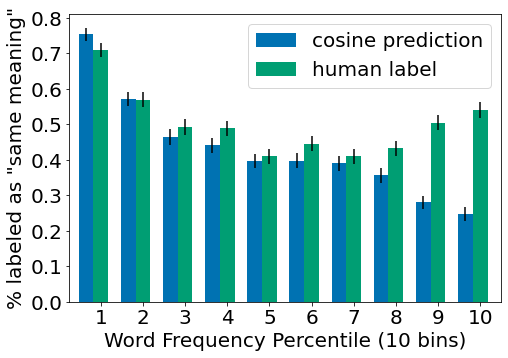

In [60]:
plt.style.use('seaborn-colorblind')

X = np.arange(10)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.65, mean_cosine,  yerr = std_cosine,  width = 0.35, label="cosine prediction")
ax.bar(X + 1, mean_human, yerr = std_human, width = 0.35, label='human label')
plt.xlim([0.25, 10.5])
plt.ylabel("% labeled as \"same meaning\"", fontsize=20)
plt.xlabel("Word Frequency Percentile (10 bins)", fontsize=20)
plt.xticks(list(range(1, 11)), fontsize=20)
plt.yticks(fontsize=20)
plt.legend(["cosine prediction", "human label"], fontsize=20)

# Miniballs Analysis

In [71]:
#Read in miniball results (which actually includes words from the dev set as well)
miniballs = pd.read_csv("../../Section_3/bounding_ball_results/wic_bounding_balls.csv")
miniballs.columns = ['keyword', 'r2', 'wiki_count', 'bookcorpus_count', 'freq']

#Keeping only words from training_set
train_miniball_data = train_data.set_index("index").join(miniballs.set_index("keyword"), how="inner", lsuffix='_l').reset_index()
train_miniball_data = train_miniball_data.dropna(subset=['cosine_similarity'])
train_miniball_data['r'] = np.sqrt(train_miniball_data['r2'])

len(train_sentences), len(train_miniball_data)

(5428, 5412)

In [72]:
# Keep only the examples where bounding balls were made
# Contingent on having at least ten examples from the corpus (with the right punctuation and captialization)
train_miniball_data = train_miniball_data.dropna(subset=['r'])
log_reg = sm.OLS(train_miniball_data['cosine_similarity'].values, train_miniball_data[['const', 'r']].values).fit()
print("\\begin{table*}")
print(log_reg.summary(xname=['Constant', 'Radius of Bounding Ball'], yname='Cosine Similarity'))
print("\\end{table*}")


\begin{table*}
                            OLS Regression Results                            
Dep. Variable:      Cosine Similarity   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     1103.
Date:                Fri, 18 Mar 2022   Prob (F-statistic):          2.51e-220
Time:                        12:06:28   Log-Likelihood:                 5534.8
No. Observations:                5412   AIC:                        -1.107e+04
Df Residuals:                    5410   BIC:                        -1.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Constant   

In [73]:
#Drop duplicates since there should be only one example per word
train_miniball_data_unique_words = train_miniball_data.drop_duplicates(subset=['index'], keep='first')
#Drop duplicates when a radius could not be calculated
train_miniball_data_unique_words = train_miniball_data_unique_words.dropna(subset=['r'])

In [74]:
import statsmodels.api as sm

v1 = ['const', 'log2(freq)']
v2 = ['const', 'log2(senses)']
v3 = ['const', 'log2(freq)', 'log2(senses)']
for variables in [v1, v2, v3]:
    log_reg = sm.OLS(train_miniball_data_unique_words[['r']].values, train_miniball_data_unique_words[variables].values).fit()
    print("\\begin{table*}")
    print(log_reg.summary(xname=variables, yname='Radius of Bounding Ball'))
    print("\\end{table*}")

\begin{table*}
                               OLS Regression Results                              
Dep. Variable:     Radius of Bounding Ball   R-squared:                       0.477
Model:                                 OLS   Adj. R-squared:                  0.477
Method:                      Least Squares   F-statistic:                     1141.
Date:                     Fri, 18 Mar 2022   Prob (F-statistic):          2.96e-178
Time:                             12:06:29   Log-Likelihood:                -2045.0
No. Observations:                     1253   AIC:                             4094.
Df Residuals:                         1251   BIC:                             4104.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [75]:
#Calculate pearson's r between training data frequency and radius of bounding ball
scipy.stats.pearsonr(x = train_miniball_data_unique_words['r'].values, y = train_miniball_data_unique_words['log2(freq)'].values)

(0.6906027696199704, 2.962406465288537e-178)